In [ ]:
import h5py
import numpy as np

X = h5py.File('data/cc3m_concat_first100k.h5', 'r')['embeddings'][:]
Y = h5py.File('data/cc3m_raw_caption_first100k.h5', 'r')['embeddings'][:]


n_samples = X.shape[0]
assert Y.shape[0] == n_samples

X = X - X.mean(axis=0, keepdims=True)
X = X / np.linalg.norm(X, axis=1, keepdims=True)
Y = Y - Y.mean(axis=0, keepdims=True)
Y = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Load Data and define utility functions

In [2]:
n_anchors = 10000
n_batch = 1024
pairs = True
device = 'cuda'

In [3]:
import torch

anchors_idx = np.random.choice(n_samples, n_anchors, replace=False)
A = torch.tensor(X[anchors_idx], device=device)
B = torch.tensor(Y[anchors_idx], device=device)

batch_idx_x = np.random.choice(n_samples, n_batch, replace=False)
batch_idx_y = batch_idx_x if pairs else np.random.choice(n_samples, n_batch, replace=False)
X_batch = torch.tensor(X[batch_idx_x], device=device)
Y_batch = torch.tensor(Y[batch_idx_y], device=device)

# Compute ground truth similariry using ground truth pairs 
X_batch_y = torch.tensor(Y[batch_idx_x], device=device)
Y_batch_x = torch.tensor(X[batch_idx_y], device=device)
K_gt = 0.5 * (X_batch @ Y_batch_x.T + Y_batch @ X_batch_y.T)

In [4]:
from ot import solve
from scipy.special import kl_div
from torch.nn.functional import softmax

def top_k_acc(K_anchors, K_gt, k=10):
    topk = torch.argsort(K_anchors, axis=1)[:, -k:]
    targets = torch.argmax(K_gt, axis=1)
    top_acc = np.mean(np.array([targets[i] in topk[i] for i in range(n_batch)]))
    return top_acc

def kl_ot(K_anchors, K_gt, eps=0.1, max_iter=1000):
    P_anchors = solve(M = 1-K_anchors, reg=eps, max_iter=max_iter).plan
    P_gt = solve(M = 1-K_gt, reg=eps, max_iter=max_iter).plan
    div = kl_div(P_anchors.cpu().numpy(), P_gt.cpu().numpy()).sum().item()
    return div 

def kl_softmax(K_anchors, K_gt, temperature=0.1):
    sm_anchors = softmax(temperature * K_anchors, dim=1)
    sm_gt = softmax(temperature * K_gt, dim=1)
    div = kl_div(sm_anchors.cpu().numpy(), sm_gt.cpu().numpy()).sum().item()
    return div 

def cosine_alignement(K_anchors, K_gt):
    K_anchors_flat = K_anchors.flatten()
    K_gt_flat = K_gt.flatten()
    cos_sim = torch.nn.functional.cosine_similarity(K_anchors_flat, K_gt_flat, dim=0)
    return cos_sim.item()

def monge_gap(K_anchors, K_gt, eps=0.1, max_iter=1000):
    '''
    Check 'how optimal' is Sinkhorn(K_anchors)
    For the OT problem min_P <P, 1-K_gt> s.t. P plan (Wasserstein)
    Normalize by the value reached by a uniform transport plan P
    '''
    P_anchors = solve(M = 1-K_anchors, reg=eps, max_iter=max_iter).plan
    P_gt = solve(M = 1-K_gt, reg=None).plan
    P_unif = torch.ones_like(P_gt) / (len(K_gt)**2)
    cost_plug_in = (P_anchors * (1 - K_gt)).sum()
    cost_opt = (P_gt * (1 - K_gt)).sum()
    cost_unif = (P_unif * (1 - K_gt)).sum()
    gap = (cost_plug_in - cost_opt)/max(cost_unif - cost_opt,1e-8)
    return gap.item()

def monge_gap_softmax(K_anchors, K_gt, temperature=1, average_row_cols=True):
    '''
    Check 'how optimal' is Softmax(K_anchors)
    For the OT problem min_P <P, 1-K_gt> s.t. sum_i Pij = 1 (semi-relaxed Wasserstein)
    Normalize by the value reached by a uniform transport plan P
    '''
    sm_anchors = softmax(temperature * K_anchors, dim=1) / len(K_gt)
    sm_gt = softmax(1000 * K_gt, dim=1) / len(K_gt) # Equivalent to argmax + one hot
    P_unif = torch.ones_like(sm_gt) / (len(K_gt)**2)
    cost_plug_in = (sm_anchors * (1 - K_gt)).sum()
    cost_opt = (sm_gt * (1 - K_gt)).sum()
    cost_unif = (P_unif * (1 - K_gt)).sum()
    gap = (cost_plug_in - cost_opt)/max(cost_unif - cost_opt,1e-8)
    gap = gap.item()
    if average_row_cols:
        return 0.5*(gap + monge_gap_softmax(K_anchors.T, K_gt.T, temperature=temperature, average_row_cols=False))
    return gap

# Compare K_anchors strategies

In [ ]:
from torch.nn.functional import log_softmax

# Simple cosine affinity between anchors 
def naive_anchor_space_cosine(X_batch, Y_batch, A, B):
    '''
    X_anchors = X_batch @ A.T
    Y_anchors = Y_batch @ B.T
    K_anchors_i,j = cosine(X_anchors[i], Y_anchors[j])
    '''
    X_anchors = X_batch @ A.T
    X_anchors = X_anchors / torch.linalg.norm(X_anchors, axis=1, keepdims=True)
    Y_anchors = Y_batch @ B.T
    Y_anchors = Y_anchors / torch.linalg.norm(Y_anchors, axis=1, keepdims=True)
    K_anchors = X_anchors @ Y_anchors.T
    return K_anchors

# Rewrite anchor vector as a probability vector via softmax, then compute negative KL divergence
def softmax_anchor_space(X_batch, Y_batch, A, B, temperature=1):
    '''
    X_anchors = softmax(X_batch @ A.T)
    Y_anchors = softmax(Y_batch @ B.T)
    K_anchors_i,j = - KL(X_anchors[i], Y_anchors[j])
    + Normalize by average absolute value
    '''
    X_anchors = X_batch @ A.T
    X_logits = log_softmax(X_anchors*temperature,-1)
    X_probs = X_logits.exp()
    Y_anchors = Y_batch @ B.T
    Y_logits = log_softmax(Y_anchors*temperature,-1)
    Y_probs = Y_logits.exp()
    K_anchors = (X_probs*X_logits).sum(-1)[:,None] - X_probs @ Y_logits.T  - X_logits @ Y_probs.T + (Y_probs*Y_logits).sum(-1)[None,:]
    K_anchors =  - K_anchors / K_anchors.abs().mean()
    return K_anchors

# Top-k anchor vector
def k_nn_anchor_space(X_batch, Y_batch, A, B, k=10):
    '''
    X_anchors = top_k(X_batch @ A.T)
    Y_anchors = top_k(Y_batch @ B.T)
    K_anchors_i,j = intersection(X_anchors[i], Y_anchors[j]) / k
    (count the number of common k-nn anchors)
    '''
    X_anchors = X_batch @ A.T
    values, indices = torch.topk(X_anchors, k, -1)
    X_one_hot = torch.zeros_like(X_anchors)
    X_one_hot.scatter_(-1, indices, 1)
    Y_anchors = Y_batch @ B.T
    values, indices = torch.topk(Y_anchors, k, -1)
    Y_one_hot = torch.zeros_like(Y_anchors)
    Y_one_hot.scatter_(-1, indices, 1)
    K_anchors = X_one_hot @ Y_one_hot.T
    K_anchors = K_anchors / k
    return K_anchors

In [17]:
from functools import partial
import pandas as pd

methods_dict = {
    'naive_cosine': naive_anchor_space_cosine,
    'softmax_kl (t=10)': partial(softmax_anchor_space, temperature=10),
    'k_nn (k=1)': partial(k_nn_anchor_space, k=1),
    'k_nn (k=10)': partial(k_nn_anchor_space, k=10),
    'k_nn (k=100)': partial(k_nn_anchor_space, k=100),
    'k_nn (k=1000)': partial(k_nn_anchor_space, k=1000),
}

metrics_dict = {
    'top-10 acc ↑': partial(top_k_acc, k=10),
    'cosine alignment ↑': cosine_alignement,
    'Monge Gap OT (eps=0.001) ↓': partial(monge_gap, eps=0.001),
    'Monge Gap Softmax (t=100) ↓': partial(monge_gap_softmax, temperature=100),
}

df = pd.DataFrame(columns=metrics_dict.keys(), index=methods_dict.keys())
for method_name, method_fn in methods_dict.items():
    K_anchors = method_fn(X_batch, Y_batch, A, B)
    for metric_name, metric_fn in metrics_dict.items():
        score = metric_fn(K_anchors, K_gt)
        df.loc[method_name, metric_name] = score

/home/krzakala/anaconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


In [18]:
df

,top-10 acc ↑,cosine alignment ↑,Monge Gap OT (eps=0.001) ↓,Monge Gap Softmax (t=100) ↓
naive_cosine,0.464844,0.624512,0.545898,0.665527
softmax_kl (t=10),0.448242,0.068848,0.477051,0.663574
k_nn (k=1),0.15332,0.170532,0.957031,0.840576
k_nn (k=10),0.609375,0.337158,0.629883,0.619629
k_nn (k=100),0.657227,0.586426,0.586426,0.615723
k_nn (k=1000),0.405273,0.448486,0.620605,0.740234


In [8]:
K_anchors = naive_anchor_space_cosine(X_batch, Y_batch, A, B)

k = 10
print(f'Top-{k} accuracy (anchors): {top_k_acc(K_anchors, K_gt, k=k):.4f}')
print(f'Cosine alignment: {cosine_alignement(K_anchors, K_gt):.4f}')
max_iter = 10
for epsilon_sinkhorn in [0.001,0.01,0.1,1]:
    print(f'Monge Gap P_anchors/P_gt: {monge_gap(K_anchors, K_gt, eps=epsilon_sinkhorn,max_iter=max_iter):.4f}')
for temperature in [0.1,1,10,100,1000,10000]:
    print(f'Monge Gap Softmax: {monge_gap_softmax(K_anchors, K_gt, temperature=temperature):.4f}')
    
epsilon_sinkhorn = 1
temperature_softmax = 0.1
print(f'KL Divergence P_anchors/P_gt: {kl_ot(K_anchors, K_gt, eps=epsilon_sinkhorn):.4f}')
print(f'KL Divergence sm_anchors/sm_gt: {kl_softmax(K_anchors, K_gt, temperature=temperature_softmax):.4f}')

Top-10 accuracy (anchors): 0.4648
Cosine alignment: 0.6245
Monge Gap P_anchors/P_gt: 0.5918
Monge Gap P_anchors/P_gt: 0.6162
Monge Gap P_anchors/P_gt: 0.9102


/home/krzakala/anaconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Monge Gap P_anchors/P_gt: 0.9946
Monge Gap Softmax: 1.0029
Monge Gap Softmax: 0.9922
Monge Gap Softmax: 0.8967
Monge Gap Softmax: 0.6655
Monge Gap Softmax: 0.6433
Monge Gap Softmax: 0.6426
KL Divergence P_anchors/P_gt: 0.0113
KL Divergence sm_anchors/sm_gt: 0.1090


# Plots

In [13]:
K_anchors = naive_anchor_space_cosine(X_batch, Y_batch, A, B)

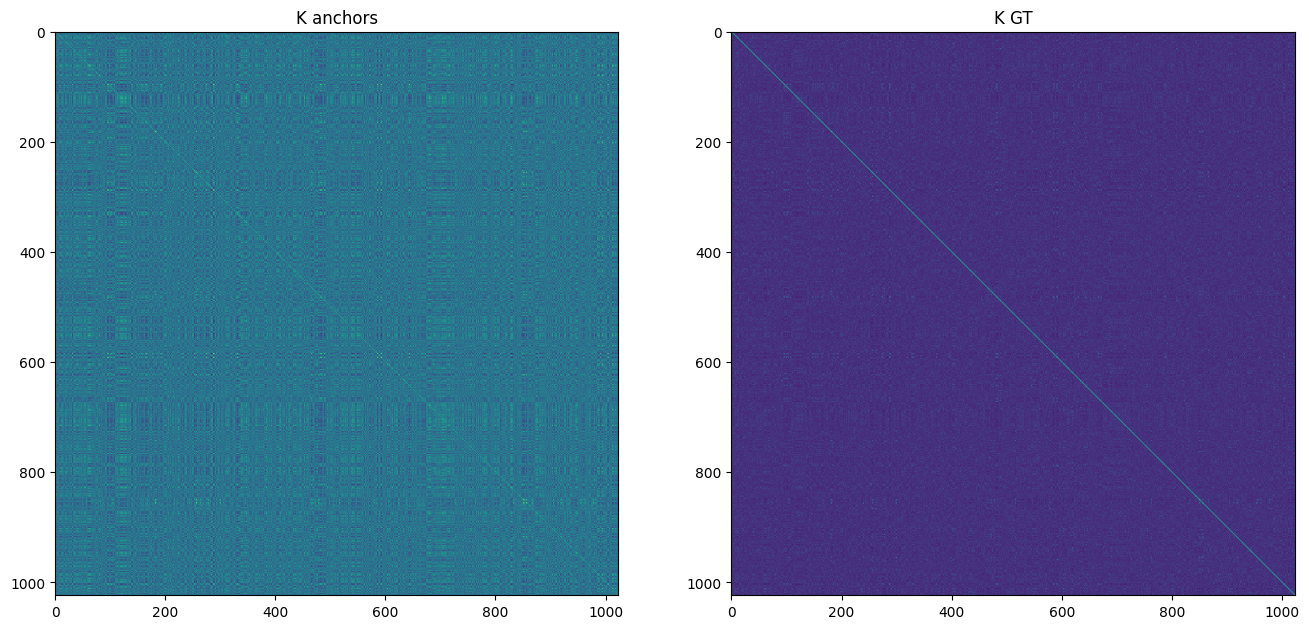

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
ax1.imshow(K_anchors.cpu())
ax2.imshow(K_gt.cpu())
ax1.set_title('K anchors')
ax2.set_title('K GT')
plt.show()


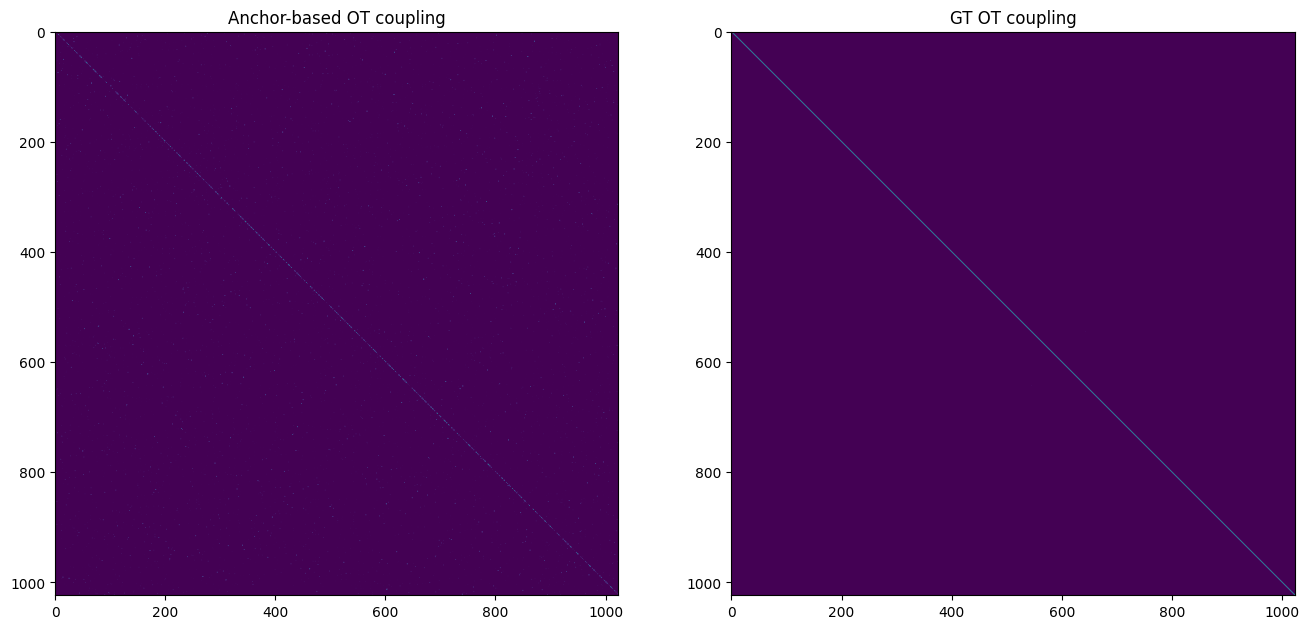

In [15]:
from ot import solve
import matplotlib.pyplot as plt

P_anchors = solve(M = 1-K_anchors, reg=0.01, max_iter=1000).plan
P_gt = solve(M = 1-K_gt, reg=0.01, max_iter=1000).plan
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
ax1.imshow(P_anchors.cpu())
ax2.imshow(P_gt.cpu())
ax1.set_title('Anchor-based OT coupling')
ax2.set_title('GT OT coupling')
plt.show()

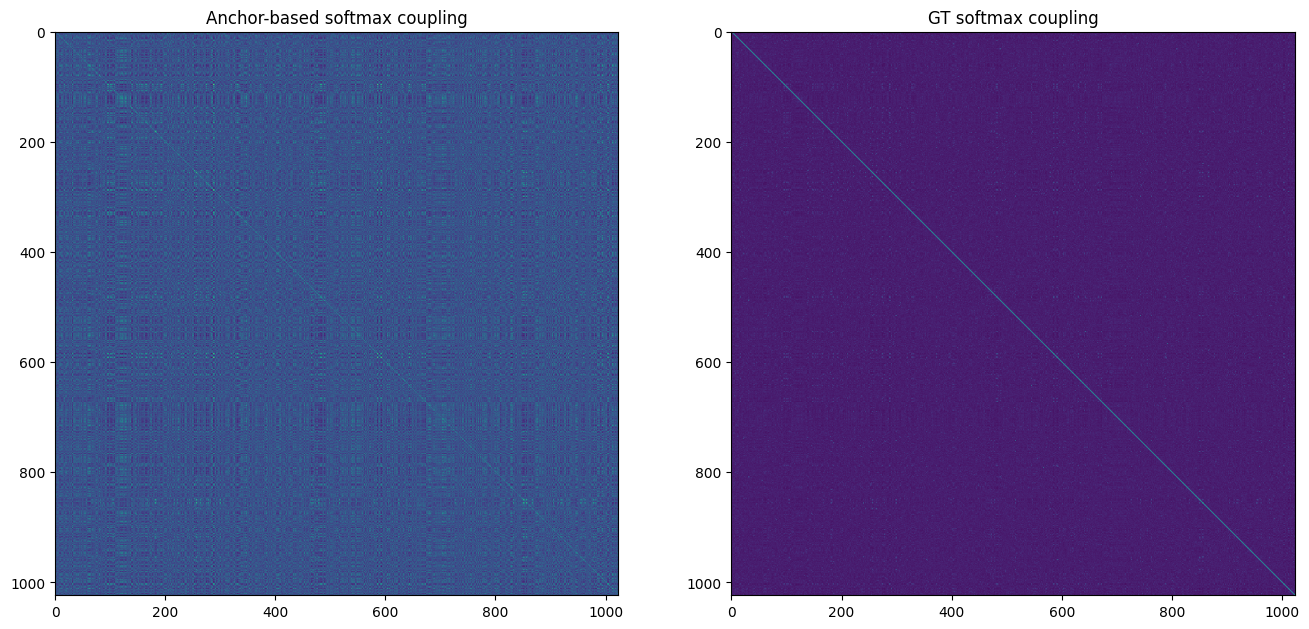

In [16]:
import matplotlib.pyplot as plt

P_anchors = K_anchors.softmax(dim=1)
P_gt = K_gt.softmax(dim=1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
ax1.imshow(P_anchors.cpu())
ax2.imshow(P_gt.cpu())
ax1.set_title('Anchor-based softmax coupling')
ax2.set_title('GT softmax coupling')
plt.show()

# Module Implementation

In [1]:
import h5py
import numpy as np

X = h5py.File('data/cc3m_concat_first100k.h5', 'r')['embeddings'][:]
Y = h5py.File('data/cc3m_raw_caption_first100k.h5', 'r')['embeddings'][:]

device = 'cuda'
n_samples = X.shape[0]
assert Y.shape[0] == n_samples

In [2]:
n_pairs = 32
n_pairs_eval = 512
k_nn_eval = 1

grid_search_cca = {
    'n_components': [-1, n_pairs//4, 32],
    'lambda_reg': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
}

grid_search_cca_old = {
    'n_components': [-1, n_pairs//4, 32],
    'lambda_reg': [0.01,0.05,0.1,0.5,1,5]
}

In [3]:
from similarity import CCA, Anchors
import torch

X_pairs, Y_pairs = X[:n_pairs], Y[:n_pairs]
X_eval, Y_eval = X[n_pairs:n_pairs+n_pairs_eval], Y[n_pairs:n_pairs+n_pairs_eval]

X_pairs, Y_pairs = torch.tensor(X_pairs, device=device,dtype=torch.float32), torch.tensor(Y_pairs, device=device,dtype=torch.float32    )
X_eval, Y_eval = torch.tensor(X_eval, device=device,dtype=torch.float32), torch.tensor(Y_eval, device=device,dtype=torch.float32)

best_acc = 0
best_params = None
for n_components in grid_search_cca['n_components']:
    for lambda_reg in grid_search_cca['lambda_reg']:
        cca = CCA(n_components=n_components, lambda_reg=lambda_reg)
        cca.fit(X_pairs, Y_pairs)
        acc = cca.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
        #print(f'CCA (n_components={n_components}, lambda_reg={lambda_reg}): Top-{k_nn_eval} accuracy = {acc:.4f}')
        if acc > best_acc:
            best_acc = acc
            best_params = (n_components, lambda_reg)

print('Grid search CCA completed.')
print(f'Best params: n_components={best_params[0]}, lambda_reg={best_params[1]}')
print(f'Best Top-{k_nn_eval} retrieval accuracy: {best_acc:.4f}')

anchors = Anchors()
anchors.fit(X_pairs, Y_pairs)
acc = anchors.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
print('')
print(f'Anchors: Top-{k_nn_eval} accuracy = {acc:.4f}')


Grid search CCA completed.
Best params: n_components=-1, lambda_reg=0.005
Best Top-1 retrieval accuracy: 0.0312

Anchors: Top-1 accuracy = 0.0254


In [4]:
from similarity import CCA_old, Anchors

X_pairs, Y_pairs = X[:n_pairs], Y[:n_pairs]
X_eval, Y_eval = X[n_pairs:n_pairs+n_pairs_eval], Y[n_pairs:n_pairs+n_pairs_eval]

X_pairs, Y_pairs = torch.tensor(X_pairs, device=device,dtype=torch.float32), torch.tensor(Y_pairs, device=device,dtype=torch.float32    )
X_eval, Y_eval = torch.tensor(X_eval, device=device,dtype=torch.float32), torch.tensor(Y_eval, device=device,dtype=torch.float32)

best_acc = 0
best_params = None
for n_components in grid_search_cca_old['n_components']:
    for lambda_reg in grid_search_cca_old['lambda_reg']:
        cca = CCA_old(n_components=n_components, lambda_reg=lambda_reg)
        cca.fit(X_pairs, Y_pairs)
        acc = cca.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
        #print(f'CCA (n_components={n_components}, lambda_reg={lambda_reg}): Top-{k_nn_eval} accuracy = {acc:.4f}')
        if acc > best_acc:
            best_acc = acc
            best_params = (n_components, lambda_reg)

print('Grid search CCA completed.')
print(f'Best params: n_components={best_params[0]}, lambda_reg={best_params[1]}')
print(f'Best Top-{k_nn_eval} retrieval accuracy: {best_acc:.4f}')

anchors = Anchors()
anchors.fit(X_pairs, Y_pairs)
acc = anchors.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
print('')
print(f'Anchors: Top-{k_nn_eval} accuracy = {acc:.4f}')

Grid search CCA completed.
Best params: n_components=32, lambda_reg=0.05
Best Top-1 retrieval accuracy: 0.0352

Anchors: Top-1 accuracy = 0.0254


In [5]:
import torch
device = 'cuda'

for lambda_reg in [1e-4, 1e-3, 1e-2, 1e-1]:
    print(f'CCA with lambda_reg={lambda_reg}')
    cca = CCA(n_components=-1, lambda_reg=lambda_reg)
    cca.fit(X_pairs, Y_pairs)
    acc = cca.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
    print(f'    Top-{k_nn_eval} retrieval accuracy: {acc:.4f}')

CCA with lambda_reg=0.0001
    Top-1 retrieval accuracy: 0.0254
CCA with lambda_reg=0.001
    Top-1 retrieval accuracy: 0.0273
CCA with lambda_reg=0.01
    Top-1 retrieval accuracy: 0.0293
CCA with lambda_reg=0.1
    Top-1 retrieval accuracy: 0.0273


In [6]:
import torch
device = 'cuda'

for lambda_reg in [1e-4, 1e-3, 1e-2, 1e-1]:
    print(f'CCA (old) with lambda_reg={lambda_reg}')
    cca = CCA_old(n_components=-1, lambda_reg=lambda_reg)
    cca.fit(X_pairs, Y_pairs)
    acc = cca.top_k_retrieval(X_eval, Y_eval, k=k_nn_eval)
    print(f'    Top-{k_nn_eval} retrieval accuracy: {acc:.4f}')

CCA (old) with lambda_reg=0.0001
    Top-1 retrieval accuracy: 0.0020
CCA (old) with lambda_reg=0.001
    Top-1 retrieval accuracy: 0.0020
CCA (old) with lambda_reg=0.01
    Top-1 retrieval accuracy: 0.0117
CCA (old) with lambda_reg=0.1
    Top-1 retrieval accuracy: 0.0137
